### Week 2 : Images as Signals & Noise removal

#### Date : 14th October, 2021

* This lab session is  is broken down into two sections, the first is just a visual demonstration therefore all you need to do is copy & paste or type out the code from task 1 and run each section.

* The second part requires you to code your own example.

#### Fourier Transform:

* We can use Fourier transforms to decompose an image into its sine and cosine components, resulting in an image in its frequency domain rather than its spatial domain. This has many implications and applications which will be discussed in class.

* Today however we wanted to demonstrate visually this decomposition process. Please note that we are showing you the signal decomposition by taking a 1D slice of the image.

#### Task 1

In [60]:
import cv2
from math import inf
import numpy as np
import matplotlib.pyplot as plt

In [61]:
# Load the image
img = cv2.imread('../images/sample_image.jpg', cv2.COLOR_BGR2RGB)

In [62]:
# convert to double and gray scale
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_gray = img_gray.astype(np.double) / 255

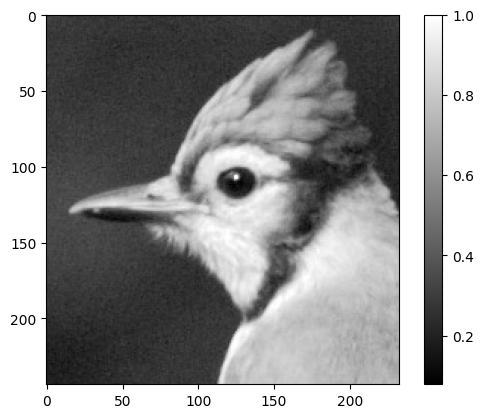

In [63]:
plt.imshow(img_gray, 'gray')
plt.colorbar()

Text(0.5, 1.0, 'Grey-level profile at 116')

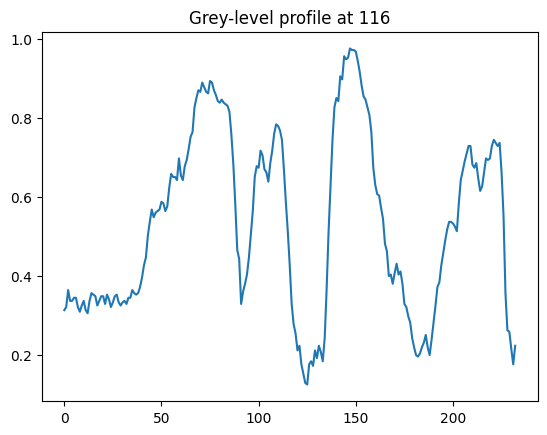

In [64]:
# Next, we take a sample of this image
row = img_gray.shape[1] // 2
x = img_gray[row, :]
plt.plot(x)
plt.title('Grey-level profile at ' + str(row))

Here, we plot the amplitude of these frequencies which is found by taking the absolute value of our FFT signal

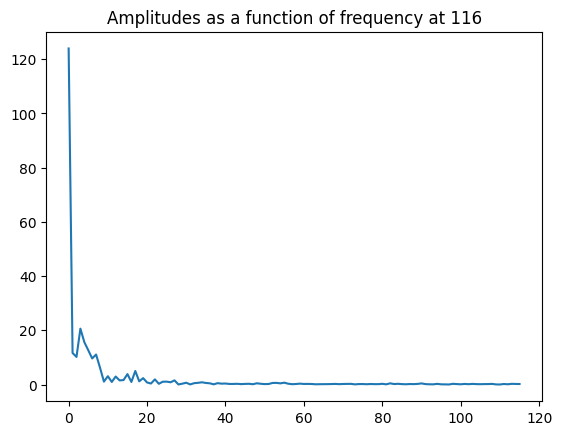

In [65]:
X = np.fft.fft(x)
N = len(x)
plt.title('Amplitudes as a function of frequency at 116')
plt.plot(np.abs(X)[:N//2])

Next we are going to see the individual components that make up this signal, showing just a sub sample of these. 

/home/davidyz/.local/share/virtualenvs/ImPro26-CyuBHqW9/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


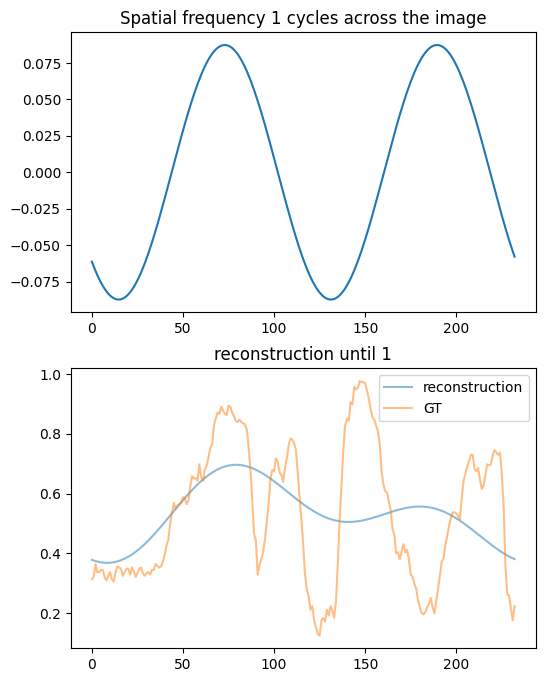

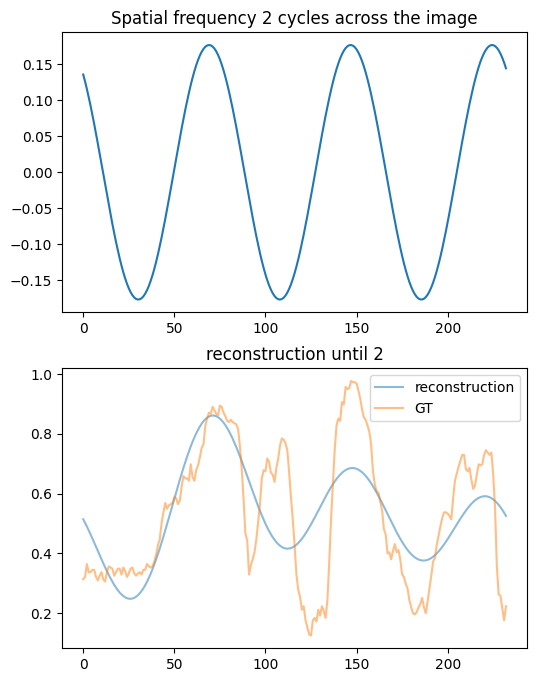

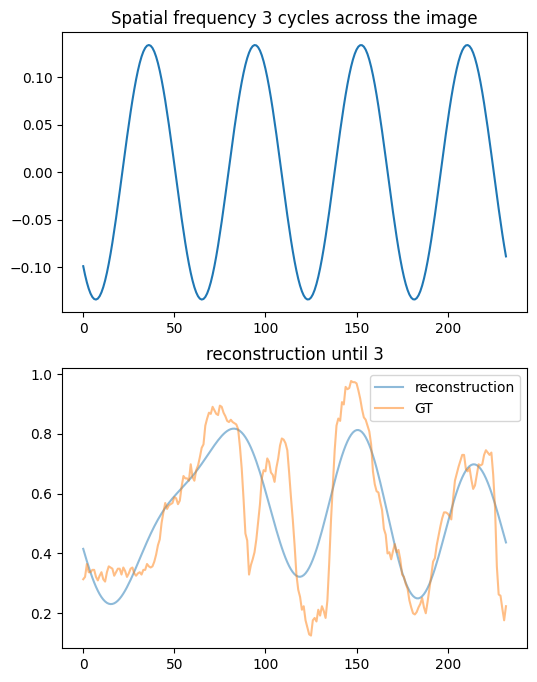

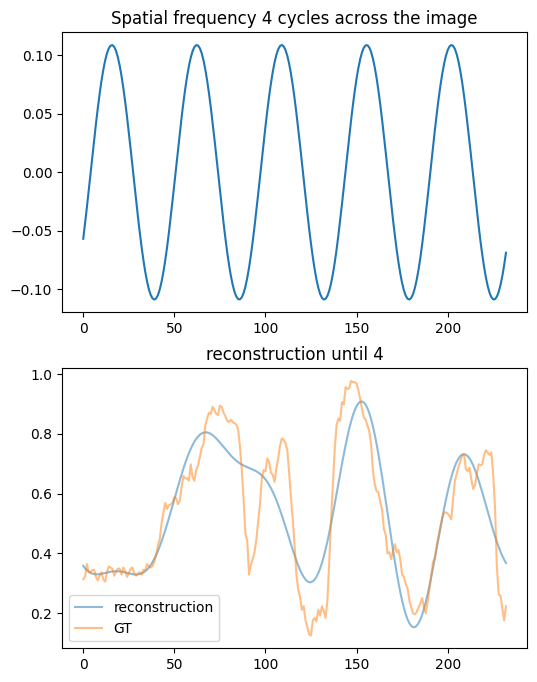

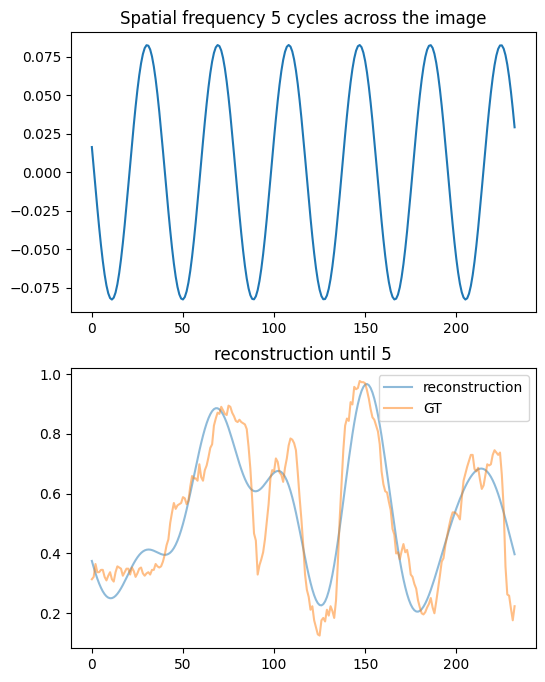

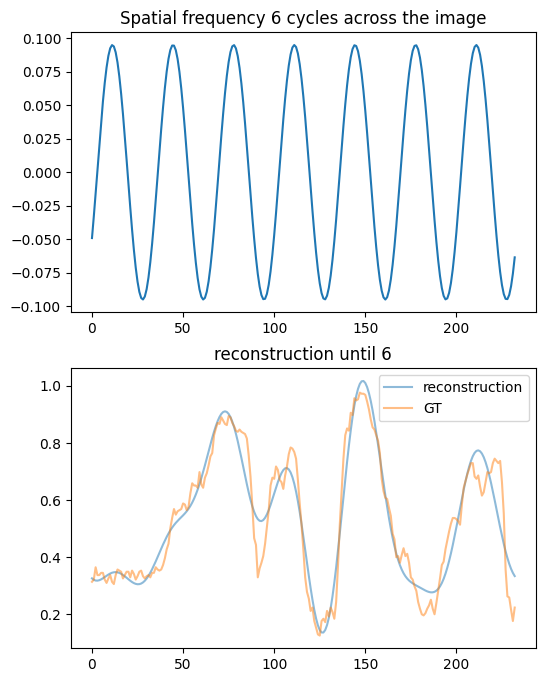

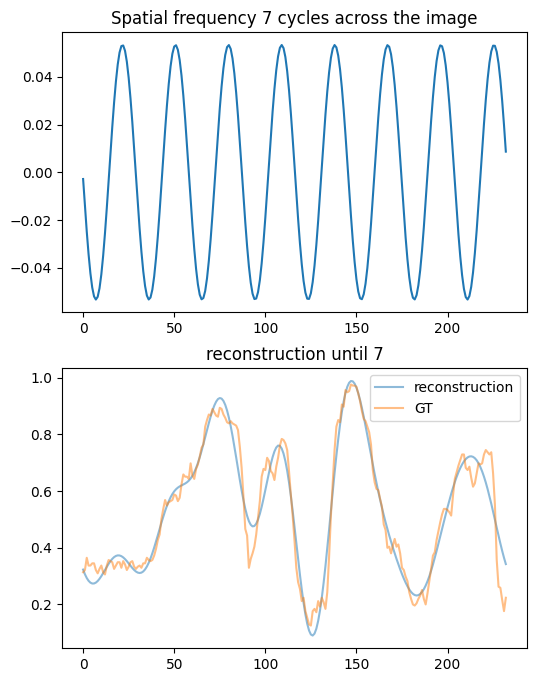

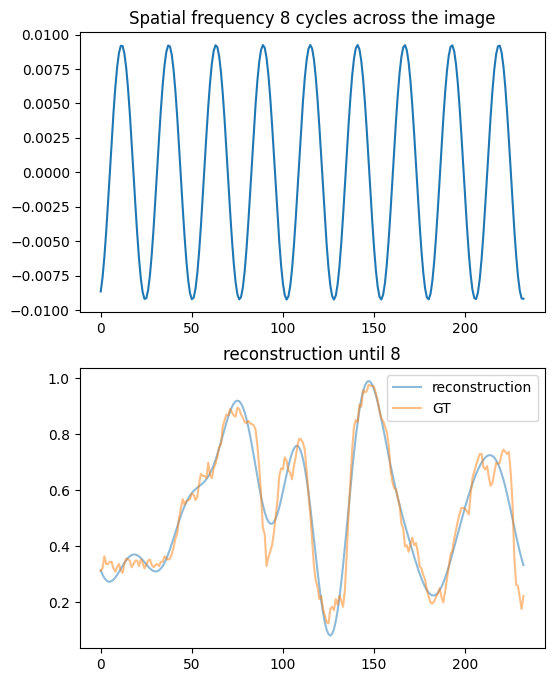

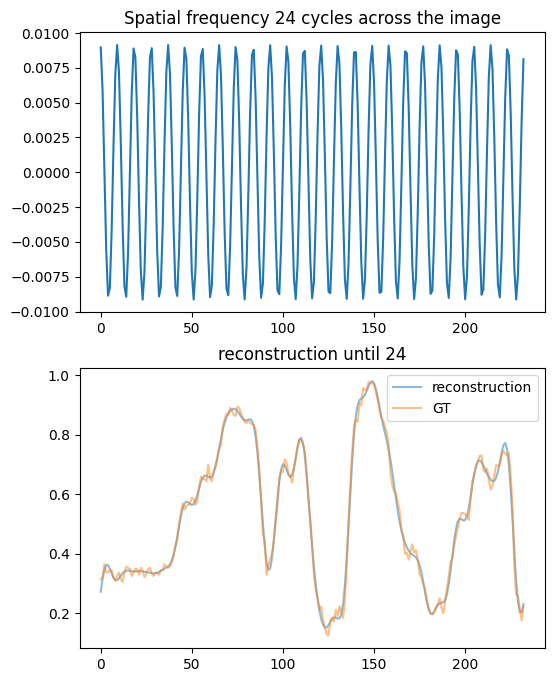

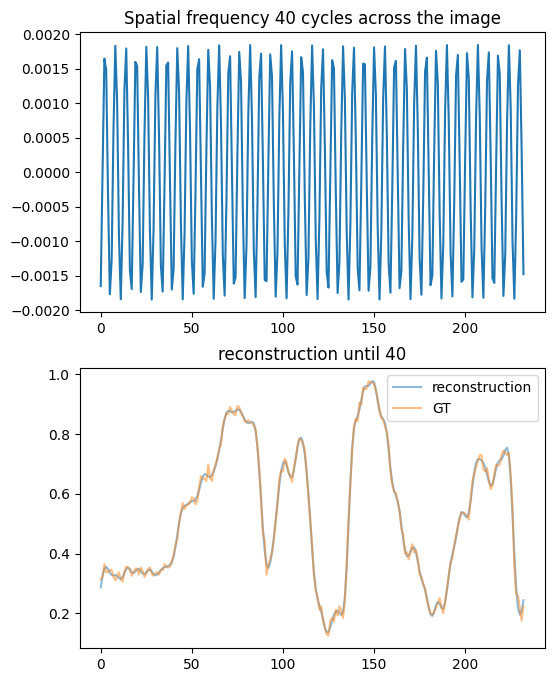

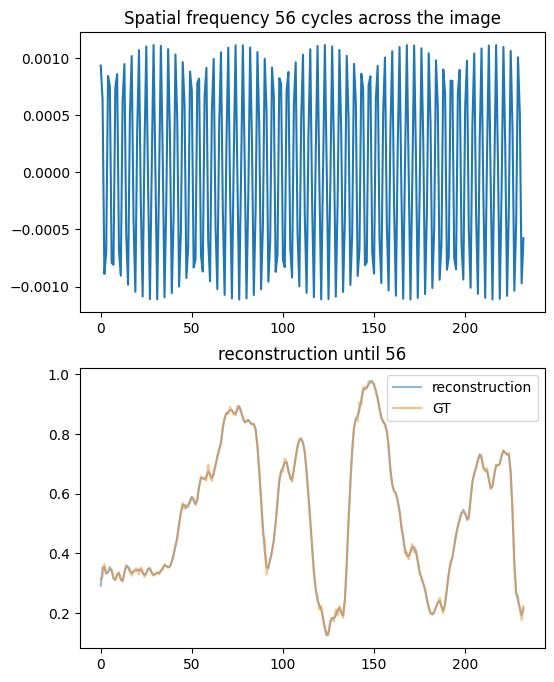

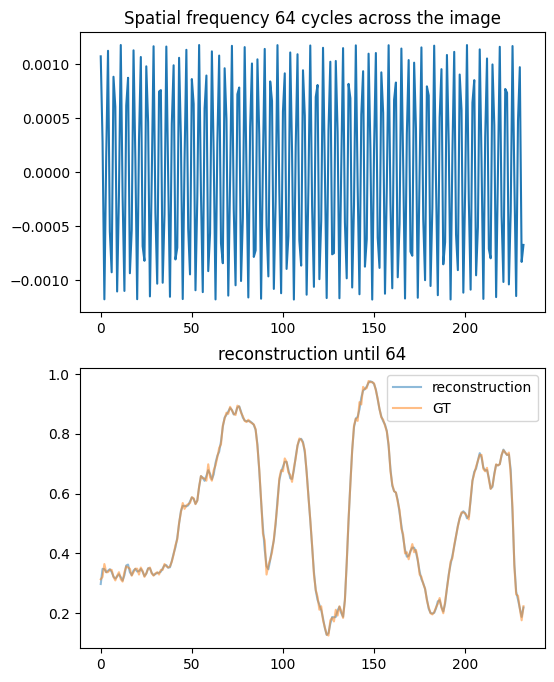

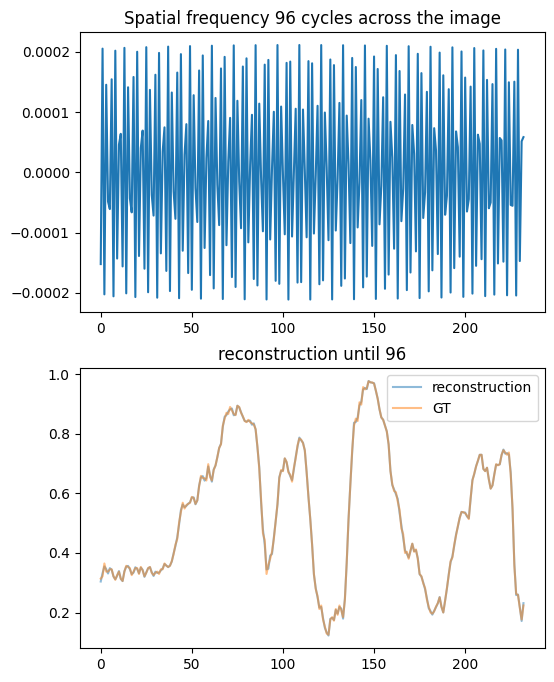

In [66]:
N = len(x)
reconstruction = X[0] / N
p = 2 * np.pi * np.arange(N) / N # 0 to 2*pi, the cycles of trigonometry functions

check_points = [i for i in range(1,8,1)] + [i for i in range(8,63,16)] + [i for i in range(64,N//2,32)]

for k in range(N//2):
    # compute the component for the frequency that 
    # gives k cycles in the width of the image
    a = X[k+1] # complex amplitude of this component
    phi = (k+1)*p # phase array
    # Take advantage of the symmetry that results from x being real
    # to ignore the top half of X
    s = 2 if k < N/2 else 1
    # a single component is a harmonic wave (sine or cosine)
    component = s*(np.real(a)*np.cos(phi) - np.imag(a)*np.sin(phi)) / N
    # and add the component to the reconstruction so far
    reconstruction = reconstruction + component
    if k in check_points:
        fig, ax = plt.subplots(2, 1, figsize=(6,8))
        
        ax[0].plot(component)
        ax[0].set_title('Spatial frequency ' + str(k) + ' cycles across the image')
        
        ax[1].plot(reconstruction, alpha=0.5, label='reconstruction')
        ax[1].plot(x, alpha=0.5, label='GT')
        ax[1].legend()
        ax[1].set_title('reconstruction until ' + str(k))
        plt.show()
    
    

### Task 2: Noise removal

* For those of you who have experienced taking images in low lighting conditions you will inevitably have come across issues with noise, this is usually caused by having to use a very high ISO level. 

* The ISO setting is used to control the speed of the camera by amplifying the sensitivity of the cameras sensor.
 
* Today we will code two simple techniques that can be used to remove or reduce this noise. This does come at a price however by removing some fine details, as you will see.

#### Median Filter

* Your first task is to write a Median Filter. To start off with I would advise that you work on gray scale images. Once you manage this you can then figure out how to apply this to a colour image.

* The median filter works by iterating over an image using a sliding window (you can set the size, I would recommend something like 3x3 or 5x5). Each pixel will be replaced with the median pixel value of the values in the box. 

* Given this below matrix

$$\begin{bmatrix} 128 & 50 & 120 \\ 10 & \color{Red}{214} & 150 \\ 127 & 157 & 137 \end{bmatrix}$$

* After the median filter, the 214 would be replaced by the median value - 128

* Please implement your code using numpy only - compare the result with opencv later


Text(0.5, 1.0, 'Median Blurred')

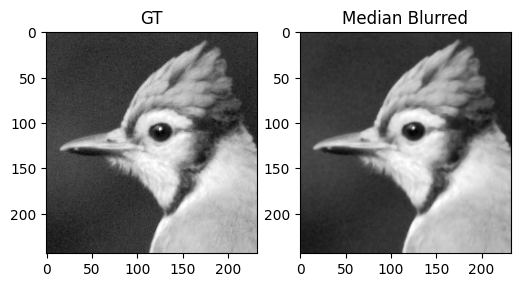

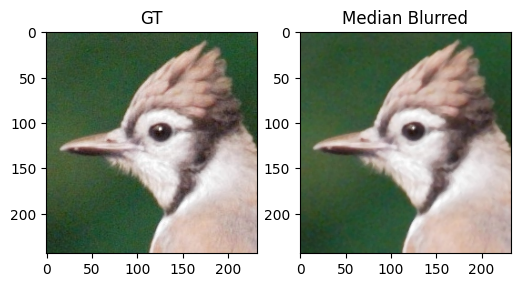

In [67]:
# Answer
def median_filter(img: np.ndarray, size: int) -> np.ndarray:
    if len(img.shape) != 2 and (len(img.shape) == 3 and img.shape[2] != 3):
        raise IndexError(f"Incorrect dimensions: {img.shape}.")
    new_img = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if len(img.shape) == 3:
                # RGB
                for channel in range(3):
                    new_img[i, j, channel] = np.median(img[i:i+size, j:j+size, channel])
            else:
                # gray_scale
                new_img[i, j] = np.median(img[i:i+size, j:j+size])
    return new_img

blur_radius = 3
fig, ax = plt.subplots(1, 2, figsize=(6,10))
ax[0].imshow(img_gray, 'gray')
ax[0].set_title('GT')
ax[1].imshow(median_filter(img_gray, blur_radius), 'gray')
ax[1].set_title('Median Blurred')


fig, ax = plt.subplots(1, 2, figsize=(6,10))
ax[0].imshow(img)
ax[0].set_title('GT')
ax[1].imshow(median_filter(img, blur_radius))
ax[1].set_title('Median Blurred')

#### Adaptive Filter

* Once you have completed the median filter on a colour image applying an Adaptive filter will be very easy. 

* This time all you need to do is compute the new pixel taking its variance into account and thus helping to preserve edges and details. This can be done using the following formula:

* Mean: 
<center>
$$\mu = \frac{1}{NM}\sum_{n_1, n_2 \in \alpha} a(n_1, n_2)$$
</center>

* Variance:
<center>
$\sigma^2 = \frac{1}{NM}\sum_{n_1, n_2 \in \alpha} a^2(n_1, n_2) - \mu^2$
</center>

* Output Pixel:
<center>
$b(n_1, n_2) = \mu + \frac{\sigma^2 - v^2}{\sigma^2}(a(n_1, n_2)-\mu)$    
</center>

where $v^2$ is the noise variance and can be either specified by the user or taken as the average of all local estimated variances

(-0.5, 939.5, 393.5, -0.5)

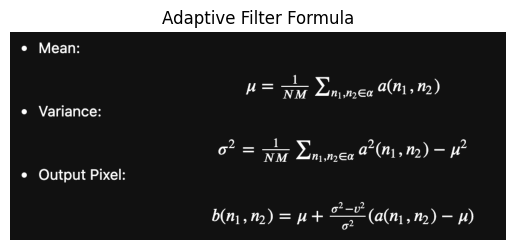

In [68]:
formula_img = cv2.imread('../images/formula_adaptive_filter.png')
plt.title('Adaptive Filter Formula')
plt.imshow(formula_img)
plt.axis('off')

* Please refer to the commented matlab code

In [69]:
# function outimg = adaptiveFilter(img, varargin)
# [sx, sy, ~] = size(img);
# %create output image
# outimg = zeros(sx,sy,1);

# if length(varargin) > 1
#     GRID_SIZE = varargin{1};
# else
#     GRID_SIZE = 3;
# end

# paddedimg = padarray(img, [floor(GRID_SIZE/2) floor(GRID_SIZE/2)], 'replicate');

# if length(varargin) > 1
#     v  = varargin{2};
# else
#     %v  = 5;
#     temp = zeros(sx,sy);
#     for i = round(GRID_SIZE/2):(sx+floor(GRID_SIZE/2))
#         for j = round(GRID_SIZE/2):(sy+floor(GRID_SIZE/2))
#             list_of_pixels = paddedimg(i-floor(GRID_SIZE/2):i+floor(GRID_SIZE/2) ...
#             , j-floor((GRID_SIZE)/2):j+floor((GRID_SIZE)/2), :);
#              %find intensity values
#              list_of_pixels = list_of_pixels(:);
#              temp(i,j) = var(double(list_of_pixels));
#         end
#     end
#     v = mean(temp(:));
# end




# %iterate through all of the pixels
# for i = round(GRID_SIZE/2):(sx+floor(GRID_SIZE/2))
#     for j = round(GRID_SIZE/2):(sy+floor(GRID_SIZE/2))
#         %use our grid to find median result
#         list_of_pixels = paddedimg(i-floor(GRID_SIZE/2):i+floor(GRID_SIZE/2) ...
#             , j-floor((GRID_SIZE)/2):j+floor((GRID_SIZE)/2), :);
#         %find intensity values
#         list_of_pixels = list_of_pixels(:);
#         mean_pixel = mean(list_of_pixels);
#         var_pixel = var(double(list_of_pixels));
#         outimg(i-floor(GRID_SIZE/2),j-floor(GRID_SIZE/2)) = mean_pixel + ( (var_pixel - v)/var_pixel )* (paddedimg(i,j) - mean_pixel);
#     end
# end

# end


/tmp/ipykernel_53721/2339015825.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  new_pix = mu + (var - noise) / var * (img[i, j] - mu)
/tmp/ipykernel_53721/2339015825.py:19: RuntimeWarning: invalid value encountered in double_scalars
  new_pix = mu + (var - noise) / var * (img[i, j] - mu)
/tmp/ipykernel_53721/2339015825.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  new_pix = mu + (var - noise[channel]) / var * (img[i, j, channel] - mu)
/tmp/ipykernel_53721/2339015825.py:28: RuntimeWarning: invalid value encountered in double_scalars
  new_pix = mu + (var - noise[channel]) / var * (img[i, j, channel] - mu)


Text(0.5, 1.0, 'Adaptive Filter')

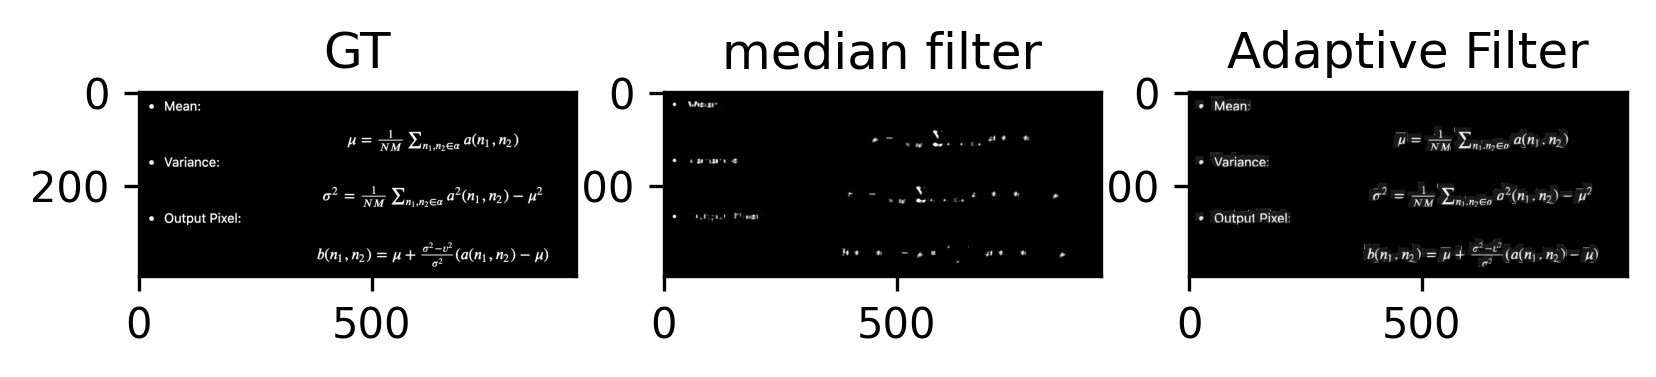

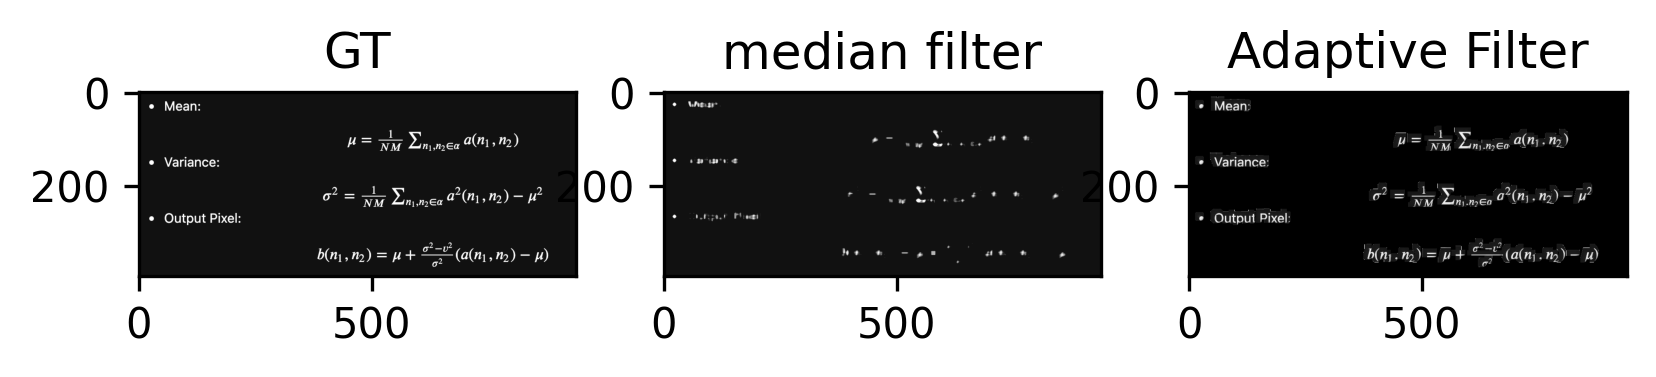

In [79]:
# One answer
def adaptive_filter(img: np.ndarray, size: int) -> np.ndarray:
    if len(img.shape) != 2 and (len(img.shape) == 3 and img.shape[2] != 3):
        raise IndexError(f"Incorrect dimensions: {img.shape}.")
    new_img = img.copy()
    shape = img.shape
    if len(shape) == 2:
        noise = np.var(img)
    else:
        noise = tuple(np.var(img[:, :, i]) for i in range(3))

    for i in range(shape[0]):
        for j in range(shape[1]):
            if len(shape) == 2:
                # gray scaled
                box = img[i:i+size, j:j+size]
                mu = np.mean(box)
                var = np.var(box)
                new_pix = mu + (var - noise) / var * (img[i, j] - mu)
                new_img[i, j] = int(min(max(0, new_pix), 255))
            else:
                # colored
                for channel in range(3):
                    box = img[i:i+size, j:j+size, channel]
                    count = size * size
                    mu = np.mean(box)
                    var = np.var(box)
                    new_pix = mu + (var - noise[channel]) / var * (img[i, j, channel] - mu)
                    new_img[i, j, channel] = int(min(max(0, new_pix), 255))
    return new_img

img = formula_img
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

bin_size = 10
fig, axes = plt.subplots(1, 3, dpi=300)
axes[0].imshow(img_gray, 'gray')
axes[0].set_title('GT')
axes[1].imshow(median_filter(img_gray, bin_size), 'gray')
axes[1].set_title('median filter')
axes[2].imshow(adaptive_filter(img_gray, bin_size), 'gray')
axes[2].set_title('Adaptive Filter')

fig, axes = plt.subplots(1, 3, dpi=300)
axes[0].imshow(img)
axes[0].set_title('GT')
axes[1].imshow(median_filter(img, bin_size))
axes[1].set_title('median filter')
axes[2].imshow(adaptive_filter(img, bin_size))
axes[2].set_title('Adaptive Filter')

#### Filtering vectorized

* Using as little number of for-loops as possible, perform median filtering on the colour input.

* The vectorized down-sampling code from last week could be a good start. Try to pre-calculate the filter kernel (the array of weights) and use the .* operator to multiply 1-D arrays with each other.

* How much space does your method need for an 11x11 median filtering on a 3 channel (uint8)image? 

* Using the package - *time* does your algorithm compare to the built-in median filtering of opencv? Also, measure the difference between your implementation and opencv